In [17]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import join 
import numpy as np

import clmm
from clmm import Cosmology
import pyccl as ccl

sys.path.append('../modules/')
import CL_WL_DATAOPS_make_profile as prf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [3]:
from scipy.integrate import quad
def av_sigma_2(zl):
    def sigma_c_2(zs):
        return cosmo.eval_sigma_crit(zl, zs)**(2)
    def Chang(z): #Chang distribution of source redshift
        a = 1.24
        b = 1.01
        z_0 = 0.51
        return np.exp(-(z/z_0)**b)*z**a
    norm = quad(Chang,0,np.inf)[0]
    print(norm)
    def __INTEGRAND__(z): return Chang(z)*sigma_c_2(z)
    return quad(__INTEGRAND__,zl + 0.1,100)[0]/norm

In [4]:
av_sigma_2(1)

0.2437764410130451


1.190128691931685e+31

In [5]:
filename = '../data/individual_profile_cosmoDC2_gal_cosmoDC2_halo_epsilon_shape_with_number_density.pkl'
profile_nsf = pickle.load(open(filename, 'rb'))
filename = '../data/individual_profile_cosmoDC2_gal_cosmoDC2_halo_shear_shape.pkl'
profile_f = pickle.load(open(filename, 'rb'))
filename = '../data/lens_catalog_SkySim5000.pkl'
dat_SkySim = pickle.load(open(filename, 'rb'))

# profile_nsf = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_cosmoDC2_gal_cosmoDC2_halo_epsilon_shape_with_number_density.pkl')
# profile_f = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_cosmoDC2_gal_cosmoDC2_halo_shear_shape.pkl')
# dat_SkySim = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/lens_catalog_SkySim5000.pkl')

In [6]:
profile_f.colnames

['cluster_id',
 'M200c',
 'cluster_z',
 'radial_bin',
 'gt_av',
 'gx_av',
 'radius_av',
 'norm_sum']

In [7]:
profile_nsf['halo_id'] = profile_nsf['cluster_id']
profile_f['halo_id'] = profile_f['cluster_id']
profile_shapenoise = join(profile_nsf,dat_SkySim,keys='halo_id')
profile_noshapenoise = join(profile_f,dat_SkySim,keys='halo_id')

In [8]:
m_SORT = np.sort(np.array(profile_f['M200c']), axis = 0)
m_list = np.array_split(m_SORT,5)
m_corner = []
for m_ in m_list[1:]:
    m_corner.append(m_[0][0])
m_corner.append(np.inf)

In [9]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = np.linspace(0.2, 1, 9)
Z_bin = binning(z_corner)
Mass_bin = binning(m_corner)

In [10]:
z_corner

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [11]:
n_boot = 100
n_jack = 150

In [12]:
profile_stack_shapenoise = prf.stacked_profile(profile = profile_shapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)
profile_stack_noshapenoise = prf.stacked_profile(profile = profile_noshapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

69
63
75
103
103
105
122
132
125
160
148
172
160
177
162
169
170
190
186
166
199
169
188
166
192
165
159
155
162
151
140
117
69
63
75
103
103
105
122
132
125
160
148
172
160
177
162
169
170
190
186
166
199
169
188
166
192
165
159
155
162
151
140
117


In [13]:
covariance_stack_bootstrap_shapenoise = prf.bootstrap_covariance(profile = profile_shapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 200,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_bootstrap_noshapenoise = prf.bootstrap_covariance(profile = profile_noshapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = n_boot,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

In [19]:
print('ok boot')

covariance_stack_sample_shapenoise = prf.sample_covariance(profile = profile_shapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                   r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_sample_noshapenoise = prf.sample_covariance(profile = profile_noshapenoise,
                    r_in = 'radius_av',
                   gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    #n_boot = n_boot,                              
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

ok boot


In [21]:
print('ok sample')

covariance_stack_jacknife_shapenoise = prf.jacknife_covariance(profile = profile_shapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                   n_jack = n_jack,
                    ra = 'ra', dec = 'dec',                                       
                   z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_jacknife_noshapenoise = prf.jacknife_covariance(profile = profile_noshapenoise,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                   n_jack = n_jack,
                    ra = 'ra', dec = 'dec',                                       
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

#print('ok jackknife')

ok sample


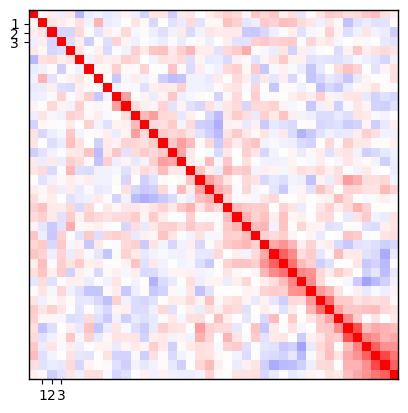

In [68]:
cov = covariance_stack_bootstrap_shapenoise['cov_t'][5]
ax = plt.gca()
def corr(cov):
    corr = np.zeros(cov.shape)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            corr[i,j] = cov[i,j]/(np.sqrt(cov[i,i]*cov[j,j]))
    return corr
extent = np.min(f_cut['radius']), np.max(f_cut['radius']), np.min(f_cut['radius']), np.max(f_cut['radius'])
ax.imshow(corr(cov), cmap='bwr', vmin=-1, vmax=1, )

ax.set_xticks([1, 2, 3])
ax.set_yticks([1, 2, 3])
plt.show()
#plt.savefig('covariance_diagonal_corr.png', bbox_inches='tight', dpi=300)

In [23]:
index_dm = 1

In [24]:
profile_f['radial_bin'][0]

array([ 0.1       ,  0.11334498,  0.12847084,  0.14561524,  0.16504757,
        0.18707313,  0.21203799,  0.24033442,  0.27240699,  0.30875965,
        0.34996355,  0.39666611,  0.44960111,  0.50960028,  0.57760633,
        0.65468776,  0.7420557 ,  0.84108286,  0.95332519,  1.08054622,
        1.22474487,  1.3881868 ,  1.57344002,  1.78341524,  2.02141161,
        2.29116854,  2.59692447,  2.94348346,  3.33629067,  3.78151792,
        4.28616064,  4.85814783,  5.50646657,  6.24130331,  7.07420385,
        8.01825478,  9.08828909, 10.30111925, 11.67580132, 13.2339344 ,
       15.        ])

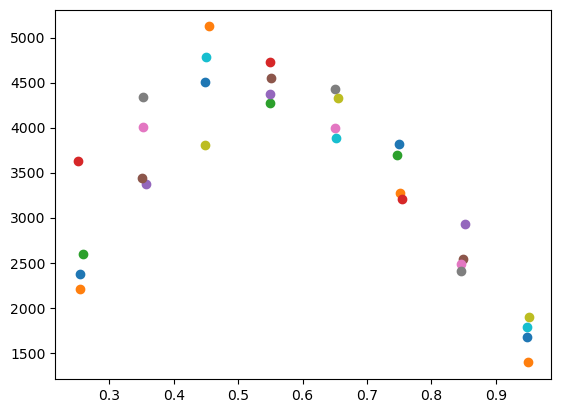

In [25]:
S = 4*np.pi*15**2 #Mpc^2
n_gal_per_bin_average = []
ns_Mpc, ns_arcmin = [],[]
sigma_2_av = []
for p in profile_stack_noshapenoise:
    cluster_id = np.array(p['cluster_id'])
    mask = np.isin(profile_nsf['cluster_id'],cluster_id)
    dm_halos_cut = profile_nsf[mask]
    average_n_gal_per_bin = np.sum(dm_halos_cut['n_gal'], axis = 0)
    average_sigma_2_per_bin = np.average(dm_halos_cut['sigma_crit^2_av'], axis = 0)
    n_gal_per_bin_average.append(average_n_gal_per_bin)
    average_n_gal_tot = np.sum(average_n_gal_per_bin)
    average_sigma_2 = np.mean(average_sigma_2_per_bin)
#   S = 4*np.pi*15**2 #Mpc^2
    ns_Mpc.append(average_n_gal_tot/S)
    theta_arcmin = 3437.75*(15/cosmo.eval_da(p['z_mean']))
    S_arcmin = np.pi*theta_arcmin**2
    ns_arcmin.append(average_n_gal_tot/S_arcmin)
    sigma_2_av.append(average_sigma_2_per_bin)
    plt.scatter(p['z_mean'], average_n_gal_tot/S_arcmin)
profile_stack_noshapenoise['ngal_per_bin'] = np.array(n_gal_per_bin_average)
profile_stack_noshapenoise['av_sigma^2'] = np.array(average_sigma_2)

0.2437764410130451
0.2437764410130451


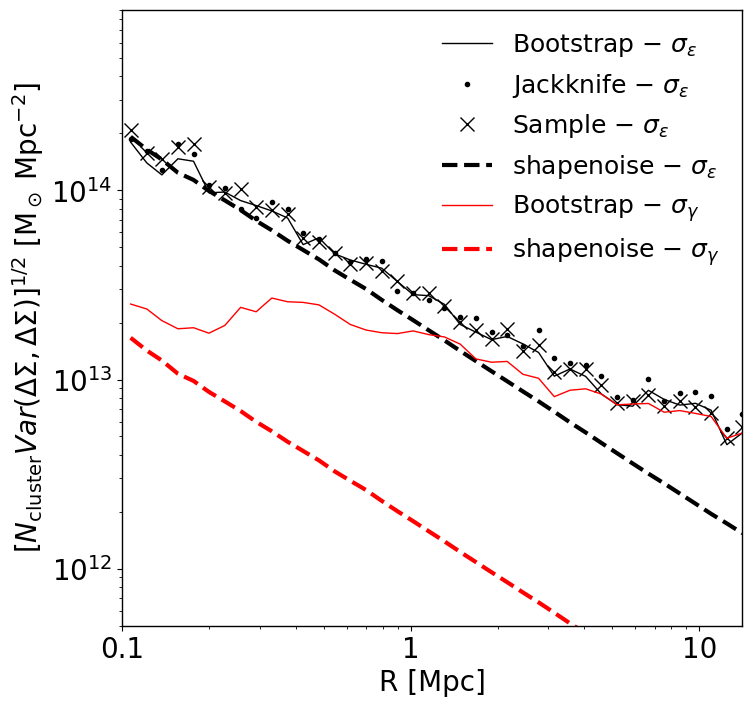

In [69]:
plt.rcParams['axes.linewidth']=1
index = index_dm
plt.figure(figsize = (8,8))
#label_z = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
#label_M = f'{np.log10(m_bin[0]):.2f}' + r'$ < \log_{10}(M_{\rm 200c}) < $' + f'{np.log10(m_bin[1]):.2f}'
#plt.plot([], [], 'w', label = label_z)
#plt.plot([], [], 'w', label = label_M)
c = ['r','b']
fmt = ['-', '--']
marker = ['o', 's']
markersize = [2,2]
name = ['center cosmoDC2', 'center RedMapper']
profile_ = profile_stack_noshapenoise
#covariance = [covariance_RedMapper_stack_bootstrap, covariance_RedMapper_stack_jacknife, covariance_RedMapper_stack_sample]
f_cut = profile_[index_dm]
std_epsilon = 0.15
std_shear = 0.013

label_boot = f'Bootstrap'
label_jack = f'Jackknife'
label_sample = 'Sample'

gt_err_bootstrap = np.sqrt(f_cut['n_stack']*np.array(covariance_stack_bootstrap_shapenoise[index_dm]['cov_t'].T.diagonal()))
gt_err_jacknife  = np.sqrt(f_cut['n_stack']*np.array(covariance_stack_jacknife_shapenoise[index_dm]['cov_t'].T.diagonal()))#/covariance_RedMapper_stack_jacknife[index_cut]['Hartlap'][0]
gt_err_sample  = np.array(f_cut['n_stack']*covariance_stack_sample_shapenoise[index_dm]['cov_t'].T.diagonal())**(1/2)
gt_err_sample_true  = np.array(f_cut['n_stack']*covariance_stack_sample_noshapenoise[index_dm]['cov_t'].T.diagonal())**(1/2)

#print(gt_err_sample)
plt.plot(f_cut['radius'], gt_err_bootstrap,'k',linewidth = 1, label = label_boot + ' $-\ \sigma_\epsilon$',)
plt.plot(f_cut['radius'], gt_err_jacknife,'.k', label = label_jack+ ' $-\ \sigma_\epsilon$', linewidth = 5)
plt.plot(f_cut['radius'], gt_err_sample,'xk', label = label_sample+ ' $-\ \sigma_\epsilon$', linewidth = 1, markersize = 10)
plt.plot(f_cut['radius'], gt_err_th_epsilon,'--k', zorder = 0, alpha = 1, linewidth = 3, label = r'shapenoise $-\ \sigma_\epsilon$')
plt.plot(f_cut['radius'], gt_err_sample_true,'-r', linewidth = 1, label = label_boot + ' $-\ \sigma_\gamma$')
gt_err_th_epsilon = (f_cut['n_stack']*av_sigma_2(f_cut['z_mean']) * std_epsilon**2/(f_cut['ngal_per_bin']))**(1/2)
gt_err_th_shear = (f_cut['n_stack']*av_sigma_2(f_cut['z_mean']) *std_shear**2/(f_cut['ngal_per_bin']))**(1/2)
plt.plot(f_cut['radius'], gt_err_th_shear,'--r', zorder = 0, alpha = 1, linewidth = 3, label = 'shapenoise $-\ \sigma_\gamma$')


plt.ylim(5e11, 9*1e14)
plt.xlim(min(f_cut['radius']), max(f_cut['radius']))
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon = False, loc = 'upper right', fontsize = 18)
plt.xlabel('R [Mpc]', fontsize = 20)
plt.ylabel(r'$[N_{\rm cluster}Var(\Delta\Sigma, \Delta\Sigma)]^{1/2}$ '+'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.xticks(ticks=[0.1, 1,10], labels=['0.1', '1','10'])
plt.tick_params(axis='both', which = 'major', labelsize= 20)
plt.savefig('covariance_diagonal.png', bbox_inches='tight', dpi=300)